In [23]:
from hrr import *
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [24]:
maze_size = 20 # Number of points
row_size = 4
col_size = int(maze_size / row_size)
goal = [5,13] # Place the session ends
reward_bad = -1 # Reward for normal tiles
reward_goal = 0 # Reward for goal tiles

action_set = ["left", "right", "up", "down"] # Available actions the agent can take

color_set = ["red", "green"]

hrr_size = 1024 # Dimensionality of the HRRs (minimum 10x maze_size)

policy_gamma = 0.9 # Delayed reward coefficient 
policy_alpha = 0.001 # Learning rate
policy_epsilon = 0.03 # Random action chance
policy_lambda = 0.1 # 

epochs = 500 
max_moves = maze_size

bias = 0.0 # Bias input for the agent 
eligibility = np.zeros([1,1,hrr_size]) 
targets = np.zeros([1,1,1]) # Q-Factored Qt values

choice_function = np.mean 

n_strats = 1

In [25]:
hidden_size = 32 # Number of nodes in hidden layers
input_layer = tf.keras.layers.Input(shape=[1,hrr_size]) # Defined input layer for HRR

# First hidden layer - nonlinear
hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=False)(input_layer)
# Second hidden layer - nonlinear
hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=False)(hidden_layer)

output_layer = tf.keras.layers.Dense(1, use_bias=False)(hidden_layer)

#c_layer = output_layer
#output_layer = tf.keras.layers.Reshape((1,1))(c_layer) # Shouldn't need due to only 1 strat

model = tf.keras.models.Model([input_layer],[output_layer])

model.compile(loss=tf.keras.losses.mse,
             optimizer=tf.keras.optimizers.SGD(learning_rate=policy_alpha))
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1, 1024)]         0         
_________________________________________________________________
dense_9 (Dense)              (None, 1, 32)             32768     
_________________________________________________________________
dense_10 (Dense)             (None, 1, 32)             1024      
_________________________________________________________________
dense_11 (Dense)             (None, 1, 1)              32        
Total params: 33,824
Trainable params: 33,824
Non-trainable params: 0
_________________________________________________________________


In [26]:
ltm = LTM(N=hrr_size, normalized=True, M=1)

suboptimal_steps = [] # performance tracker for 

In [27]:

def selection_function(action_votes):
    (x,y) = np.unique(action_votes, return_counts=True)
    return x[y.argmax()]

def logmod(x):
    return np.sign(x)*np.log(np.abs(x)+1.0)

def encode(state, action, signal, wm="I"):
    comp = "state"+str(state)+"*"+str(action)+"*"+str(signal) + "*"+"wm_"+str(wm)
    return np.array([ltm.encode(comp)])

def maxq(state, signal, wm):
    hrr = np.vstack([encode(state, action, signal) for action in action_set])
    hrr_wm = np.vstack([encode(state, action, signal, wm) for action in action_set])
    hrrs = np.vstack([hrr, hrr_wm])
    values = model.predict(hrrs)+bias
    max_actions = values.argmax(0)
    action = max_actions[values.argmax()%n_strats][0]
    return [np.hstack([values[max_actions[x],x:x+1,:] for x in range(n_strats)]),
            hrrs[action:action+1,:,:],
            action_set[action%len(action_set)]]

def greedyq(state, signal, wm):
    hrr = np.vstack([encode(state, action, signal) for action in action_set])
    hrr_wm = np.vstack([encode(state, action, signal, wm) for action in action_set])
    hrrs = np.vstack([hrr, hrr_wm])
    
    values = model.predict(hrrs)+bias
    max_actions = values.argmax(0)
    action = max_actions[values.argmax()%n_strats][0]
    return [values[action:action+1,:,:],
            hrrs[action:action+1,:,:],
            action_set[action%len(action_set)],
            wm]

def randomgreedyq(state):
    hrr = np.vstack([encode(state, action_set[0]), encode(state, action_set[1])])
    values = model.predict(hrr)+bias
    max_actions = values.argmax(0)
    action = max_actions[np.random.choice(n_strats)][0]
    return [values[action:action+1,:,:],
            hrr[action:action+1,:,:],
            action_set[action]]

def randomq(state, signal, wm):
    eligibility[:,:,:] = 0.0
    action = np.random.choice(action_set)
    hrr = encode(state, action, signal)
    value = model.predict(hrr)+bias
    return [value,
            hrr,
            action,
            wm]

In [28]:
for epoch in range(epochs):
    eligibility[:,:,:] = 0
    current_state = np.random.choice(range(maze_size))
    goal_idx = np.random.choice(range(len(color_set)))
    optimal_steps = min((current_state-goal[goal_idx])%maze_size,  (goal[goal_idx]-current_state)%maze_size)
    current_signal = color_set[goal_idx]
    
    current_wm = current_signal # Automatically remember first signal as no input gate in use
    
    if(epoch+1) % 10 == 0:
        print('\rEpisode:', (epoch+1), end='')
        
    for step in range(max_moves):
        if current_state == goal[goal_idx]:
            break
        
        if np.random.random() < policy_epsilon:
            [current_value, current_hrr, current_action] = randomq(current_state)
        else:
            [current_value, current_hrr, current_action, current_wm] = greedyq(current_state, current_wm)
            
        previous_value = current_value
        previous_hrr = current_hrr
        previous_wm = current_wm
        
        if current_action == action_set[0]:
            current_state = current_state-1
            current_state = current_state+row_size if (current_state+1) % row_size == 0 else current_state
        elif current_action == action_set[1]:
            current_state = (current_state+1)
            current_state = current_state-row_size if current_state % row_size == 0 else current_state
        elif current_action == action_set[2]:
            current_state = (current_state-row_size)%maze_size
        elif current_action == action_set[3]:
            current_state = (current_state+row_size)%maze_size
            
        if current_state == goal[goal_idx]:
            delta = reward_goal - previous_value
            target = logmod(delta) + previous_value
        else:
            [current_value,_,_] = maxq(current_state)
            delta = (reward_bad + (policy_gamma * current_value)) - previous_value
            target = logmod(delta) + previous_value
            
        current_signal = "I"
            
        targets[:,:,:] = target
        
        eligibility = (policy_lambda * eligibility) + previous_hrr
        
        model.fit(eligibility, targets-bias, verbose=0)
        
    suboptimal_steps.append(step - optimal_steps)
            

Episode: 500

[[-0.49377626 -0.4627711  -0.32577938 -0.22442077 -0.24554707 -0.37692082
  -0.18942048 -0.35865417 -0.22230703 -0.30521712 -0.47435927 -0.2940318
  -0.5021924  -0.38978353 -0.20761031 -0.41807666 -0.3893884  -0.22278515
  -0.41872615 -0.17192322]
 [-0.3756876  -0.32870474 -0.42774302 -0.49145806 -0.7046104  -0.52699
  -0.35428312 -0.42351955 -0.46673065 -0.43366462 -0.29364032 -0.38302943
  -0.24381892 -0.43032438 -0.36832777 -0.5666008  -0.47342    -0.28705856
  -0.20166476 -0.44347903]
 [-0.2813344  -0.23289815 -0.35868987 -0.21620646 -0.1798986  -0.25867304
  -0.48175627 -0.4275651  -0.49923044 -0.41217047 -0.22037482 -0.32355946
  -0.39734477 -0.3348539  -0.18015617 -0.24921747 -0.4079525  -0.2981222
  -0.5751139  -0.3233015 ]
 [-0.6097629  -0.38539773 -0.33447662 -0.33933914 -0.24951382 -0.6508326
  -0.26589364 -0.5425024  -0.37301177 -0.19775139 -0.30648276 -0.6756013
  -0.29607043 -0.48800725 -0.3038752  -0.4201357  -0.426856   -0.56866574
  -0.39600912 -0.47415498]
 [-0.281275

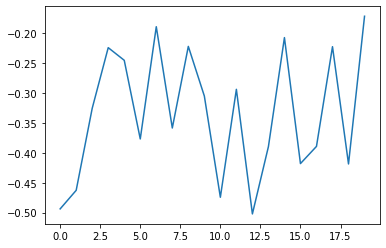

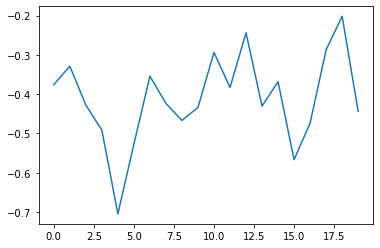

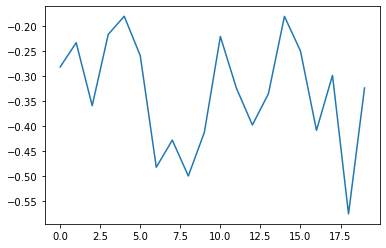

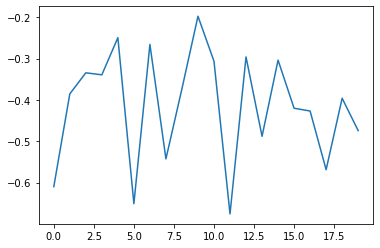

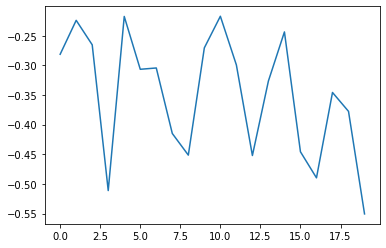

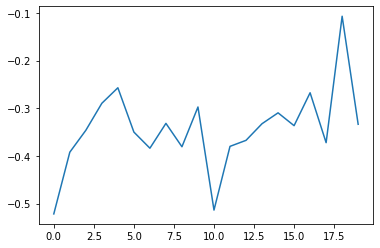

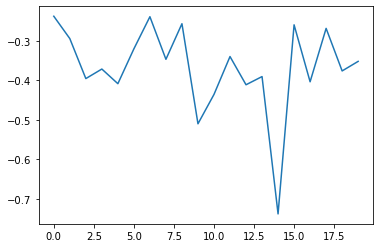

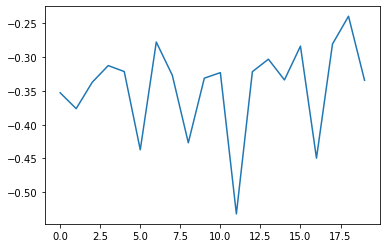

In [39]:
data = []

for action in action_set:
    pick = []
    for color in color_set:
        pick += [choice_function(model.predict(encode(state, action, color))+bias) for state in range(maze_size)]
    data += pick
    
# Format for showing all on one graph
data = np.reshape(data, [len(action_set)*len(color_set),maze_size])

print(data)

for pick in data:
    plt.plot(pick)
    plt.show()